In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

import opt_utils #参见数据包或者在本文底部copy
import testCase  #参见数据包或者在本文底部copy

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


E:\ml\DL-AndrewNG\ch2week2优化算法\opt_utils.py:76: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
E:\ml\DL-AndrewNG\ch2week2优化算法\opt_utils.py:77: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], 1)


## 梯度下降

In [2]:
def update_parameters_with_gd(parameters,grads,learning_rate):
    """
    使用梯度下降更新参数
    
    参数：
        parameters - 字典，包含了要更新的参数：
            parameters['W' + str(l)] = Wl
            parameters['b' + str(l)] = bl
        grads - 字典，包含了每一个梯度值用以更新参数
            grads['dW' + str(l)] = dWl
            grads['db' + str(l)] = dbl
        learning_rate - 学习率
        
    返回值：
        parameters - 字典，包含了更新后的参数
    """
    
    L = len(parameters) // 2 #神经网络的层数
    
    #更新每个参数
    for l in range(L):
        parameters["W" + str(l +1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l +1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    
    return parameters


## 获取mini-batch

In [3]:
def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
    """
    从（X，Y）中创建一个随机的mini-batch列表
    
    参数：
        X - 输入数据，维度为(输入节点数量，样本的数量)
        Y - 对应的是X的标签，【1 | 0】（蓝|红），维度为(1,样本的数量)
        mini_batch_size - 每个mini-batch的样本数量
        
    返回：
        mini-bacthes - 一个同步列表，维度为（mini_batch_X,mini_batch_Y）
        
    """
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    # 1.打乱次序
    permutation = list(np.random.permutation(m)) # 返回长度m的随机数组，值：0 -- m-1
    shuffled_X = X[:,permutation]
    shuffled_Y = Y[:,permutation]
    
    # 2.分割
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0,num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size:(k+1)*mini_batch_size]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # mini_batch_size是否可以整除训练集大小m
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size:]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

## 动量梯度下降法

In [4]:
def initialize_velocity(parameters):
    L = len(parameters) // 2
    v = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

    return v

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        v["dW" + str(l + 1)] = beta * v["dW" + str(l + 1)] + (1-beta) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta * v["db" + str(l + 1)] + (1-beta) * grads["db" + str(l + 1)]
        
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v["db" + str(l + 1)]
    
    return parameters,v

## Adam算法

In [25]:
def initialize_adam(parameters):
    L = len(parameters) // 2
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
        
        s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

    return (v,s)

def update_parameters_with_adam(parameters,grads,v,s,t,learning_rate=0.01,beta1=0.9,beta2=0.999,epsilon=1e-8):
    """
    使用Adam更新参数
    
    参数：
        parameters - 包含了以下字段的字典：
            parameters['W' + str(l)] = Wl
            parameters['b' + str(l)] = bl
        grads - 包含了梯度值的字典，有以下key值：
            grads['dW' + str(l)] = dWl
            grads['db' + str(l)] = dbl
        v - Adam的变量，第一个梯度的移动平均值，是一个字典类型的变量
        s - Adam的变量，平方梯度的移动平均值，是一个字典类型的变量
        t - 当前迭代的次数
        learning_rate - 学习率
        beta1 - 动量，超参数,用于第一阶段，使得曲线的Y值不从0开始（参见天气数据的那个图）
        beta2 - RMSprop的一个参数，超参数
        epsilon - 防止除零操作（分母为0）
    
    返回：
        parameters - 更新后的参数
        v - 第一个梯度的移动平均值，是一个字典类型的变量
        s - 平方梯度的移动平均值，是一个字典类型的变量
    """
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}
    
    for l in range(L):
        #梯度的移动平均值,输入："v , grads , beta1",输出：" v "
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads["db" + str(l + 1)]
        
        #计算第一阶段的偏差修正后的估计值，输入"v , beta1 , t" , 输出："v_corrected"
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1,t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1,t))
    
        #计算平方梯度的移动平均值，输入："s, grads , beta2"，输出："s"
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.square(grads["dW" + str(l + 1)])
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.square(grads["db" + str(l + 1)])
         
        #计算第二阶段的偏差修正后的估计值，输入："s , beta2 , t"，输出："s_corrected"
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2,t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2,t))
        
        #更新参数，输入: "parameters, learning_rate, v_corrected, s_corrected, epsilon". 输出: "parameters".
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * (v_corrected["dW" + str(l + 1)] / (np.sqrt(s_corrected["dW" + str(l + 1)]) + epsilon))
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * (v_corrected["db" + str(l + 1)] / (np.sqrt(s_corrected["db" + str(l + 1)]) + epsilon))
    
    return (parameters,v,s)

## 测试效果
### 加载数据集

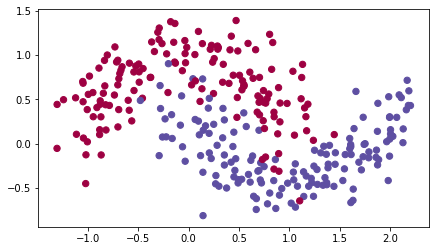

In [27]:
train_X, train_Y = opt_utils.load_dataset(is_plot=True)

### 模型

In [28]:
def model(X, Y, layers_dims, optimizer, learning_rate=0.0007,
         mini_batch_size=64, beta=0.9, beta1=0.9, beta2=0.999,
         epsilon=1e-8, num_epochs=10000, print_cost=True, is_plot=True):
    L = len(layers_dims)
    costs = []
    t = 0 #每学习完一个minibatch就增加1
    seed = 10 #随机种子
    
    #初始化参数
    parameters = opt_utils.initialize_parameters(layers_dims)
    
    #选择优化器
    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v,s = initialize_adam(parameters)
    else:
        print("optimizer参数错误。")
        exit(1)
        
    for i in range(num_epochs):
        seed = seed + 1
        mini_batches = random_mini_batches(X, Y, mini_batch_size, seed)
        
        for minibatch in mini_batches:
            (minibatch_X, minibatch_Y) = minibatch
            
            # 前向
            A, cache = opt_utils.forward_propagation(minibatch_X, parameters)
            
            # 计算损失
            cost = opt_utils.compute_cost(A, minibatch_Y)
            
            #后向
            grads = opt_utils.backward_propagation(minibatch_X, minibatch_Y, cache)
            
            #更新参数
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters,grads,learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters,grads,v,beta,learning_rate)
            elif optimizer == "adam":
                t = t + 1 
                parameters , v , s = update_parameters_with_adam(parameters,grads,v,s,t,learning_rate,beta1,beta2,epsilon)
            
        if i % 100 == 0:
            costs.append(cost)
            if print_cost and i % 1000 == 0:
                print("第" + str(i) + "次遍历整个数据集，当前误差值：" + str(cost))
        
    if is_plot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('epochs (per 100)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()
    
    return parameters

In [ ]:
#使用普通的梯度下降
layers_dims = [train_X.shape[0],5,2,1]
parameters = model(train_X, train_Y, layers_dims, optimizer="gd",is_plot=True)


Accuracy: 0.94


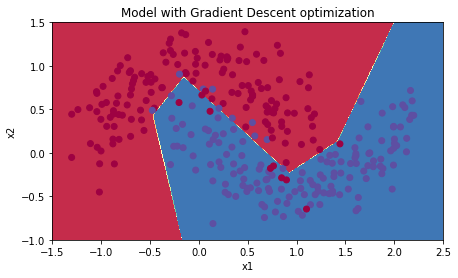

In [30]:
#预测
preditions = opt_utils.predict(train_X,train_Y,parameters)

#绘制分类图
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
opt_utils.plot_decision_boundary(lambda x: opt_utils.predict_dec(parameters, x.T), train_X, train_Y)


In [ ]:
layers_dims = [train_X.shape[0],5,2,1]
#使用动量的梯度下降
parameters = model(train_X, train_Y, layers_dims, beta=0.9,optimizer="momentum",is_plot=True)

第0次遍历整个数据集，当前误差值：0.6905522282919487
第1000次遍历整个数据集，当前误差值：0.18556718628565544
第2000次遍历整个数据集，当前误差值：0.15085206145242488
第3000次遍历整个数据集，当前误差值：0.07445357759814118
第4000次遍历整个数据集，当前误差值：0.12593575021785644
第5000次遍历整个数据集，当前误差值：0.10423511812705896
第6000次遍历整个数据集，当前误差值：0.10055245705471476
第7000次遍历整个数据集，当前误差值：0.03160142195361448
第8000次遍历整个数据集，当前误差值：0.11170898322507423
第9000次遍历整个数据集，当前误差值：0.19764808191072572


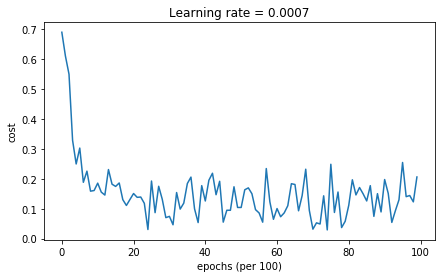

In [29]:
 layers_dims = [train_X.shape[0], 5, 2, 1]
#使用Adam优化的梯度下降
parameters = model(train_X, train_Y, layers_dims, optimizer="adam",is_plot=True)